In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pickle as pkl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generating the data for the computation of the electromagnetic tensor

In [ ]:
'''
Generates the electric field generated by charges at charge_locations at the point test_location
'''
def apply_E(source_positions, source_charges, test_positions):

    # Calculate distances between all pairs of test_positions and source_positions
    distances = np.linalg.norm(test_positions[:, np.newaxis] - source_positions, axis=2)

    # Calculate unit vectors between all pairs of test_positions and source_positions
    r_hat = (test_positions[:, np.newaxis] - source_positions) / distances[..., np.newaxis]

    # Calculate electric fields due to each source for all test_positions
    electric_fields = source_charges.reshape(1,-1,1) * r_hat / distances[..., np.newaxis]**2

    # Sum up electric fields from all sources for each test_position
    total_electric_field = electric_fields.sum(axis=1)
    
    return total_electric_field

def apply_B(source_positions, source_charges, source_velocities, target_positions):


    # Calculate distances between all pairs of test_positions and source_positions
    distances = np.linalg.norm(target_positions[:, np.newaxis] - source_positions, axis=2)

    # Calculate unit vectors between all pairs of test_positions and source_positions
    r_hat = (target_positions[:, np.newaxis] - source_positions) / distances[..., np.newaxis]

    # Calculate the current at each source_position
    currents = source_charges[:, np.newaxis] * source_velocities

    # Calculate the magnetic field contribution for each source at each test_position
    magnetic_fields = np.cross(currents[np.newaxis, :, :], r_hat) * (1.0 / (4 * np.pi * distances[..., np.newaxis]**2))

    # Sum up the magnetic fields from all sources for each
    total_magnetic_field = magnetic_fields.sum(axis=1)
    
    return total_magnetic_field

def make_F(E, B):
    F = np.zeros((N, d+1, d+1))
    F[:, 1:, 0] = E
    F[:, 0, 1:] = -E
    F[:, 1, 2] = -B[:, 2]
    F[:, 1, 3] = B[:, 1]
    F[:, 2, 3] = -B[:, 0]
    
    F[:, 2, 1] = B[:, 2]
    F[:, 3, 1] = -B[:, 1]
    F[:, 3, 2] = B[:, 0]
    
    return F

#S = Outer product of E and B
def make_S(E, B):
    return  np.einsum('ij,ik->ijk', E, B)

In [ ]:
def make_S_all_steps(source_positions, source_charges, source_velocities, target_positions):
    E = apply_E(source_positions, source_charges, target_positions)
    B = apply_B(source_positions, source_charges, source_velocities, target_positions)
    S = make_S(E, B)
    return S

In [ ]:
def random_o3_action():
    # Generate a random 3x3 matrix
    random_matrix = np.random.randn(3, 3)

    # Perform QR decomposition
    Q, R = np.linalg.qr(random_matrix)


    return Q

# Generate a random O(3) action
o3_action = random_o3_action()
print(o3_action)


[[-0.43364136  0.69790406  0.56998693]
 [-0.57676132  0.27102485 -0.77064383]
 [-0.69231608 -0.66292945  0.28499648]]


In [ ]:
# Parameters
N = 100 # number of sample points
n = 10 # Number of charges 
d = 3 # dimensions 

In [ ]:
# Generating the points
np.random.seed(1234)
source_positions = np.random.randn(n,d)
source_velocities = np.random.randn(n, d)
source_charges = np.ones((n))
target_positions = np.random.randn(N,d)


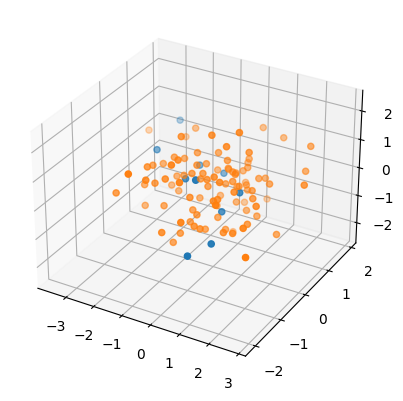

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(source_positions[:,0], source_positions[:,1], source_positions[:,2],'r')
ax.scatter(target_positions[:,0], target_positions[:,1], target_positions[:,2],'b')
plt.show()

In [ ]:
#https://academic.mu.edu/phys/matthysd/web004/l0220.htm
# https://en.wikipedia.org/wiki/Electromagnetic_tensor

In [ ]:
A = random_o3_action()

In [ ]:
SA = make_S_all_steps(source_positions @ A.T, source_charges, source_velocities @ A.T, target_positions @ A.T)
AS = A @ make_S_all_steps(source_positions , source_charges, source_velocities , target_positions) @ A.T
print(f"err = {np.linalg.norm(SA - AS)/np.linalg.norm(SA)}")

err = 9.993586879422553e-16


In [ ]:
print("Model parameters")
print(source_charges.shape)

print("Dimension of network inputs")
print(source_positions.shape[1])
print("Number of vectors")
print(source_positions.shape[0] + source_velocities.shape[0]+1)

print("Network Output")
print(SA.shape)

Model parameters
(10,)
Dimension of network inputs
3
Number of vectors
21
Network Output
(100, 3, 3)
